# Introduction

In the classifications so far undertaken all the classes have been directly compared to one another. However, using the image mask input on all the classification functions you can select which pixels are being considered for the classification and therefore create a hierarchical. Hierarchical classifications have some advantages in that you reduce the amount of work (i.e., number of classes being compared) each classifier is doing which can help the accuracy of each step. However, if an error occurs in the earlier part of the hierarchy (i.e., miss classification of veg vs non-veg) then that will be carried through the rest of the classification hierarchy. 

The structure used for the following example is shown in Figure below.

![heirarch_cls](figures/hierarchical_classification_structure.png)


# 1. Import Modules

In [1]:
import os

import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rsgislib
import rsgislib.classification
import rsgislib.classification.classxgboost
import rsgislib.tools.plotting
import rsgislib.tools.utils
import rsgislib.vectorutils
import rsgislib.zonalstats
from rsgislib.classification import ClassInfoObj

# Import the function to calculate the accuracy stats
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples
from rsgislib.imageutils import ImageBandInfo

/Users/pete/miniforge3/envs/osgeo-env-v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 2. Create Output Directories

In [2]:
out_cls_dir = "cls_hier_results"
if not os.path.exists(out_cls_dir):
    os.mkdir(out_cls_dir)

out_pts_dir = "acc_pts"
if not os.path.exists(out_pts_dir):
    os.mkdir(out_pts_dir)

out_stats_dir = "acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)

# 3. Input Data

In [3]:
input_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"
imgs_info = []
imgs_info.append(
    ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)

valid_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif"

# 4. Create Veg / Non-Veg Classification

## 4.1 Merge Veg / Non-Veg Sample Data

In [4]:
# Train
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/bracken_refl_smpls_train.h5",
        "training_data/conifer_forest_refl_smpls_train.h5",
        "training_data/deciduous_forest_refl_smpls_train.h5",
        "training_data/grass_long_refl_smpls_train.h5",
        "training_data/grass_short_refl_smpls_train.h5",
        "training_data/scrub_refl_smpls_train.h5",
    ],
    "cls_hier_results/veg_train_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/artificial_surfaces_refl_smpls_train.h5",
        "training_data/bare_rock_sand_refl_smpls_train.h5",
        "training_data/nonphoto_veg_refl_smpls_train.h5",
        "training_data/water_refl_smpls_train.h5",
    ],
    "cls_hier_results/nonveg_train_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

# Test
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/bracken_refl_smpls_test.h5",
        "training_data/conifer_forest_refl_smpls_test.h5",
        "training_data/deciduous_forest_refl_smpls_test.h5",
        "training_data/grass_long_refl_smpls_test.h5",
        "training_data/grass_short_refl_smpls_test.h5",
        "training_data/scrub_refl_smpls_test.h5",
    ],
    "cls_hier_results/veg_test_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/artificial_surfaces_refl_smpls_test.h5",
        "training_data/bare_rock_sand_refl_smpls_test.h5",
        "training_data/nonphoto_veg_refl_smpls_test.h5",
        "training_data/water_refl_smpls_test.h5",
    ],
    "cls_hier_results/nonveg_test_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

# Valid
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/bracken_refl_smpls_valid.h5",
        "training_data/conifer_forest_refl_smpls_valid.h5",
        "training_data/deciduous_forest_refl_smpls_valid.h5",
        "training_data/grass_long_refl_smpls_valid.h5",
        "training_data/grass_short_refl_smpls_valid.h5",
        "training_data/scrub_refl_smpls_valid.h5",
    ],
    "cls_hier_results/veg_valid_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/artificial_surfaces_refl_smpls_valid.h5",
        "training_data/bare_rock_sand_refl_smpls_valid.h5",
        "training_data/nonphoto_veg_refl_smpls_valid.h5",
        "training_data/water_refl_smpls_valid.h5",
    ],
    "cls_hier_results/nonveg_valid_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

## 4.2 Train Veg / Non-Veg Classifier

In [5]:
veg_train = "cls_hier_results/veg_train_cls_samples.h5"
veg_test = "cls_hier_results/veg_test_cls_samples.h5"
veg_valid = "cls_hier_results/veg_valid_cls_samples.h5"

non_veg_train = "cls_hier_results/nonveg_train_cls_samples.h5"
non_veg_test = "cls_hier_results/veg_test_cls_samples.h5"
non_veg_valid = "cls_hier_results/nonveg_valid_cls_samples.h5"

out_mdl_file = "cls_hier_results/veg_nonveg_xgb_mdl.h5"
rsgislib.classification.classxgboost.train_opt_xgboost_binary_classifier(
    out_mdl_file,
    veg_train,
    veg_valid,
    veg_test,
    non_veg_train,
    non_veg_valid,
    non_veg_test,
)

Reading Class 1 Training
num_cls1_train_rows = 2110
Reading Class 1 Validation
num_cls1_valid_rows = 310
Reading Class 1 Testing
num_cls1_test_rows = 310
Reading Class 2 Training
num_cls2_train_rows = 1430
Reading Class 2 Validation
num_cls2_valid_rows = 224
Reading Class 2 Testing
num_cls2_test_rows = 310
Finished Reading Data
scale_pos_weight = 1

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}
num_boost_round = 31.

AUROC..... 0.9996327764976958 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}
num_boost_round = 84.

AUROC..... 0.9999063940092165 .....iter.....

Next set of params..... {'eta': 0.31028258277136894, 'g

## 4.3 Apply Veg / Non-Veg Classifier

In [6]:
out_prob_non_veg_img = "cls_hier_results/veg_prob_cls.kea"
out_cls_non_veg_img = "cls_hier_results/veg_cls.kea"

rsgislib.classification.classxgboost.apply_xgboost_binary_classifier(
    out_mdl_file,
    valid_img,
    1,
    imgs_info,
    out_prob_non_veg_img,
    "KEA",
    out_class_img=out_cls_non_veg_img,
    class_thres=5000,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed


Calculating Image Pyramids.

New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 4.4 Create Veg / Non-Veg Mask

In [7]:
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("veg", out_cls_non_veg_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("msk", valid_img, 1))

out_cls_veg_nonveg_img = "cls_hier_results/veg_nonveg_cls.kea"
rsgislib.imagecalc.band_math(
    out_cls_veg_nonveg_img,
    "(msk==1)&&(veg==1)?1:(msk==1)&&(veg==0)?2:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)

rsgislib.rastergis.pop_rat_img_stats(
    out_cls_veg_nonveg_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif
	 Variable 'msk' is band 1
Image: cls_hier_results/veg_cls.kea
	 Variable 'veg' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 4.5 Visualise Classification

Image Data Size: 3295 x 2880


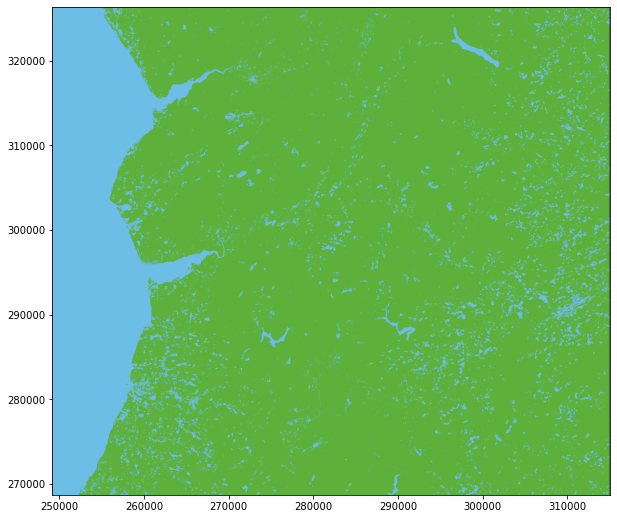

In [8]:
# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_cls_veg_nonveg_img)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# 5. Classify Non-Photosynthetic Classes

 * Non-Photosynthetic Veg
 * Water
 * Bare Surfaces

## 5.1 Merge Bare Surfaces Samples

In [9]:
# Train
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/artificial_surfaces_refl_smpls_train.h5",
        "training_data/bare_rock_sand_refl_smpls_train.h5",
    ],
    "cls_hier_results/baresurface_train_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

# Test
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/artificial_surfaces_refl_smpls_test.h5",
        "training_data/bare_rock_sand_refl_smpls_test.h5",
    ],
    "cls_hier_results/baresurface_test_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

# Valid
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/artificial_surfaces_refl_smpls_valid.h5",
        "training_data/bare_rock_sand_refl_smpls_valid.h5",
    ],
    "cls_hier_results/baresurface_valid_cls_samples.h5",
    datatype=rsgislib.TYPE_16UINT,
)

## 5.2 Train Classifier (Bare, Water, Non-Photo Veg)

In [10]:
cls_train_info = dict()
cls_train_info["Bare"] = ClassInfoObj(
    id=0,
    out_id=1,
    train_file_h5="cls_hier_results/baresurface_train_cls_samples.h5",
    test_file_h5="cls_hier_results/baresurface_test_cls_samples.h5",
    valid_file_h5="cls_hier_results/baresurface_valid_cls_samples.h5",
    red=160,
    green=160,
    blue=160,
)
cls_train_info["NonPhoto_Veg"] = ClassInfoObj(
    id=1,
    out_id=2,
    train_file_h5="training_data/nonphoto_veg_refl_smpls_train.h5",
    test_file_h5="training_data/nonphoto_veg_refl_smpls_test.h5",
    valid_file_h5="training_data/nonphoto_veg_refl_smpls_valid.h5",
    red=98,
    green=225,
    blue=227,
)
cls_train_info["Water"] = ClassInfoObj(
    id=2,
    out_id=3,
    train_file_h5="training_data/water_refl_smpls_train.h5",
    test_file_h5="training_data/water_refl_smpls_test.h5",
    valid_file_h5="training_data/water_refl_smpls_valid.h5",
    red=0,
    green=0,
    blue=255,
)


# Train the classifier
out_mdl_file = os.path.join(out_cls_dir, "nonveg_cls_xgb_mdl.h5")
rsgislib.classification.classxgboost.train_opt_xgboost_multiclass_classifier(
    out_mdl_file, cls_train_info
)

Reading Class Bare Training
Reading Class Bare Validation
Reading Class Bare Testing
Reading Class NonPhoto_Veg Training
Reading Class NonPhoto_Veg Validation
Reading Class NonPhoto_Veg Testing
Reading Class Water Training
Reading Class Water Validation
Reading Class Water Testing
Finished Reading Data

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 3}
num_boost_round = 31.

AccScore..... 0.9955357142857143 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 3}
num_boost_round = 84.

AccScore..... 0.9955357142857143 .....iter.....

Next set of params..... {'eta': 0.31028258277136894, 'gamma': 

## 5.3 Apply Classifier (Bare, Water, Non-Photo Veg)

In [11]:
# Apply the classifier to the image
out_nonveg_clses_img = os.path.join(out_cls_dir, "nonveg_clses_xgb.kea")
rsgislib.classification.classxgboost.apply_xgboost_multiclass_classifier(
    cls_train_info,
    out_mdl_file,
    out_cls_veg_nonveg_img,
    2,
    imgs_info,
    out_nonveg_clses_img,
    "KEA",
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed Classification
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'Bare'
Apply Colour to class 'NonPhoto_Veg'
Apply Colour to class 'Water'


## 5.4 Train Bare Surface Classes

In [12]:
cls_train_info = dict()
cls_train_info["Artificial_Surfaces"] = ClassInfoObj(
    id=0,
    out_id=1,
    train_file_h5="training_data/artificial_surfaces_refl_smpls_train.h5",
    test_file_h5="training_data/artificial_surfaces_refl_smpls_test.h5",
    valid_file_h5="training_data/artificial_surfaces_refl_smpls_valid.h5",
    red=160,
    green=160,
    blue=160,
)
cls_train_info["Bare_Rock_Sand"] = ClassInfoObj(
    id=1,
    out_id=2,
    train_file_h5="training_data/bare_rock_sand_refl_smpls_train.h5",
    test_file_h5="training_data/bare_rock_sand_refl_smpls_test.h5",
    valid_file_h5="training_data/bare_rock_sand_refl_smpls_valid.h5",
    red=100,
    green=100,
    blue=100,
)

# Train the classifier
out_mdl_file = os.path.join(out_cls_dir, "bare_cls_xgb_mdl.h5")
rsgislib.classification.classxgboost.train_opt_xgboost_multiclass_classifier(
    out_mdl_file, cls_train_info
)

Reading Class Artificial_Surfaces Training
Reading Class Artificial_Surfaces Validation
Reading Class Artificial_Surfaces Testing
Reading Class Bare_Rock_Sand Training
Reading Class Bare_Rock_Sand Validation
Reading Class Bare_Rock_Sand Testing
Finished Reading Data

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 2}
num_boost_round = 31.

AccScore..... 0.8557692307692307 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 2}
num_boost_round = 84.

AccScore..... 0.8557692307692307 .....iter.....

Next set of params..... {'eta': 0.31028258277136894, 'gamma': 65, 'max_depth': 9, 'min_child_weight

## 5.5 Apply Bare Surface Classes

In [13]:
# Apply the classifier to the image
out_bare_cls_img = os.path.join(out_cls_dir, "bare_cls_xgb.kea")
rsgislib.classification.classxgboost.apply_xgboost_multiclass_classifier(
    cls_train_info,
    out_mdl_file,
    out_nonveg_clses_img,
    1,
    imgs_info,
    out_bare_cls_img,
    "KEA",
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed Classification
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'Artificial_Surfaces'
Apply Colour to class 'Bare_Rock_Sand'


## 5.6 Combine Classifications

In [14]:
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("bare", out_bare_cls_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("nonveg", out_nonveg_clses_img, 1))
out_cls_fnl_nonveg_img = os.path.join(out_cls_dir, "nonveg_fnl_cls.kea")
rsgislib.imagecalc.band_math(
    out_cls_fnl_nonveg_img,
    "(bare==1)?1:(bare==2)?2:(nonveg==2)?3:(nonveg==3)?4:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)

rsgislib.rastergis.pop_rat_img_stats(
    out_cls_fnl_nonveg_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: cls_hier_results/bare_cls_xgb.kea
	 Variable 'bare' is band 1
Image: cls_hier_results/nonveg_clses_xgb.kea
	 Variable 'nonveg' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 5.7 Visualise Classification

Image Data Size: 3295 x 2880


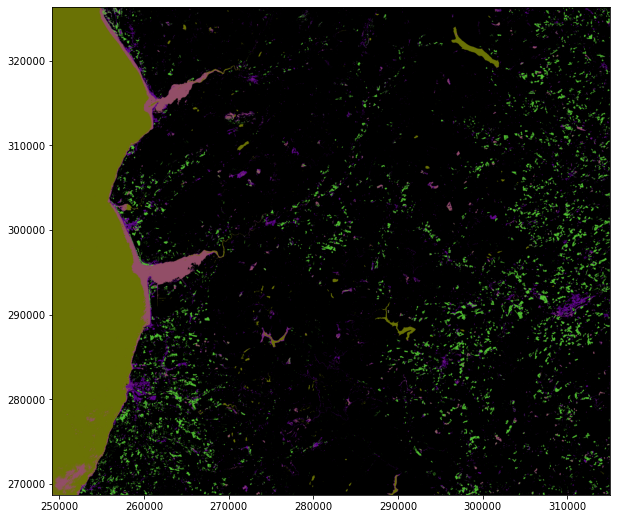

In [15]:
# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_cls_fnl_nonveg_img)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# 6. Classify Woody Vegetation

## 6.1 Merge Veg and Woody Veg Samples

In [16]:
# Train
not_woody_train_samples = "cls_hier_results/notwoody_train_cls_samples.h5"
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/bracken_refl_smpls_train.h5",
        "training_data/grass_long_refl_smpls_train.h5",
        "training_data/grass_short_refl_smpls_train.h5",
        "training_data/scrub_refl_smpls_train.h5",
    ],
    not_woody_train_samples,
    datatype=rsgislib.TYPE_16UINT,
)

woody_train_samples = "cls_hier_results/woody_train_cls_samples.h5"
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/conifer_forest_refl_smpls_train.h5",
        "training_data/deciduous_forest_refl_smpls_train.h5",
    ],
    woody_train_samples,
    datatype=rsgislib.TYPE_16UINT,
)

# Test
not_woody_test_samples = "cls_hier_results/notwoody_test_cls_samples.h5"
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/bracken_refl_smpls_test.h5",
        "training_data/grass_long_refl_smpls_test.h5",
        "training_data/grass_short_refl_smpls_test.h5",
        "training_data/scrub_refl_smpls_test.h5",
    ],
    not_woody_test_samples,
    datatype=rsgislib.TYPE_16UINT,
)

woody_test_samples = "cls_hier_results/woody_test_cls_samples.h5"
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/conifer_forest_refl_smpls_test.h5",
        "training_data/deciduous_forest_refl_smpls_test.h5",
    ],
    woody_test_samples,
    datatype=rsgislib.TYPE_16UINT,
)

# Valid
not_woody_valid_samples = "cls_hier_results/notwoody_valid_cls_samples.h5"
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/bracken_refl_smpls_valid.h5",
        "training_data/grass_long_refl_smpls_valid.h5",
        "training_data/grass_short_refl_smpls_valid.h5",
        "training_data/scrub_refl_smpls_valid.h5",
    ],
    not_woody_valid_samples,
    datatype=rsgislib.TYPE_16UINT,
)

woody_valid_samples = "cls_hier_results/woody_valid_cls_samples.h5"
rsgislib.zonalstats.merge_extracted_hdf5_data(
    [
        "training_data/conifer_forest_refl_smpls_valid.h5",
        "training_data/deciduous_forest_refl_smpls_valid.h5",
    ],
    woody_valid_samples,
    datatype=rsgislib.TYPE_16UINT,
)

## 6.2 Train Classifier (Non-Woody and Woody)

In [17]:
out_mdl_file = "cls_hier_results/woody_veg_xgb_mdl.h5"
rsgislib.classification.classxgboost.train_opt_xgboost_binary_classifier(
    out_mdl_file,
    woody_train_samples,
    woody_valid_samples,
    woody_test_samples,
    not_woody_train_samples,
    not_woody_valid_samples,
    not_woody_test_samples,
)

Reading Class 1 Training
num_cls1_train_rows = 706
Reading Class 1 Validation
num_cls1_valid_rows = 105
Reading Class 1 Testing
num_cls1_test_rows = 104
Reading Class 2 Training
num_cls2_train_rows = 1404
Reading Class 2 Validation
num_cls2_valid_rows = 205
Reading Class 2 Testing
num_cls2_test_rows = 206
Finished Reading Data
scale_pos_weight = 1.9886685552407932

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}
num_boost_round = 31.

AUROC..... 0.994541231126597 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}
num_boost_round = 84.

AUROC..... 0.9993960511033682 .....iter.....

Next set of params..... {'eta': 0.310282

## 6.3 Apply Classifier (Non-Woody and Woody)

In [18]:
out_prob_img = "cls_hier_results/woody_veg_bin_prob_cls.kea"
out_cls_veg_woody_img = "cls_hier_results/woody_veg_bin_cls.kea"

rsgislib.classification.classxgboost.apply_xgboost_binary_classifier(
    out_mdl_file,
    out_cls_veg_nonveg_img,
    1,
    imgs_info,
    out_prob_img,
    "KEA",
    out_class_img=out_cls_veg_woody_img,
    class_thres=5000,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed


Calculating Image Pyramids.

New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 6.3 Combine Classifications

In [19]:
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("wveg", out_cls_veg_woody_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("msk", out_cls_veg_nonveg_img, 1))
out_cls_veg_woody_fnl_img = "cls_hier_results/woody_veg_msk_cls.kea"
rsgislib.imagecalc.band_math(
    out_cls_veg_woody_fnl_img,
    "(msk==1)&&(wveg==1)?1:(msk==1)&&(wveg==0)?2:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)

rsgislib.rastergis.pop_rat_img_stats(
    out_cls_veg_woody_fnl_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: cls_hier_results/veg_nonveg_cls.kea
	 Variable 'msk' is band 1
Image: cls_hier_results/woody_veg_bin_cls.kea
	 Variable 'wveg' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 6.4 Visualise Woody Veg Classification

Image Data Size: 3295 x 2880


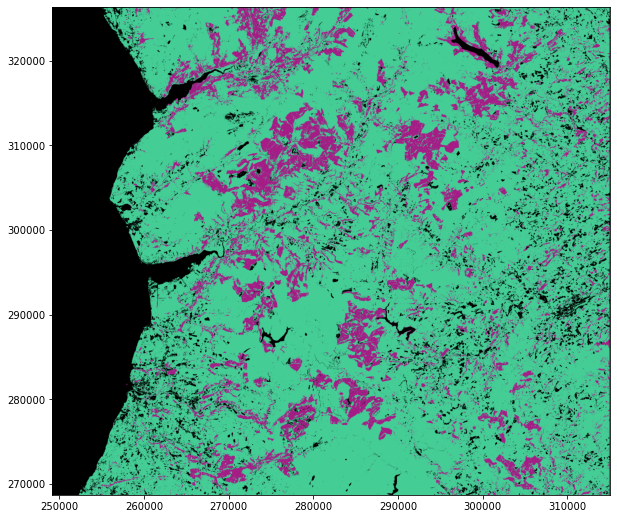

In [20]:
# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    out_cls_veg_woody_fnl_img
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# 7. Classify Woody Veg Types

## 7.1 Train Woody Veg Types Classifier

In [21]:
cls_train_info = dict()
cls_train_info["Conifer_Forest"] = ClassInfoObj(
    id=0,
    out_id=1,
    train_file_h5="training_data/conifer_forest_refl_smpls_train.h5",
    test_file_h5="training_data/conifer_forest_refl_smpls_test.h5",
    valid_file_h5="training_data/conifer_forest_refl_smpls_valid.h5",
    red=2,
    green=97,
    blue=16,
)
cls_train_info["Deciduous_Forest"] = ClassInfoObj(
    id=1,
    out_id=2,
    train_file_h5="training_data/deciduous_forest_refl_smpls_train.h5",
    test_file_h5="training_data/deciduous_forest_refl_smpls_test.h5",
    valid_file_h5="training_data/deciduous_forest_refl_smpls_valid.h5",
    red=50,
    green=184,
    blue=69,
)

# Train the classifier
out_woody_veg_types_mdl_file = os.path.join(out_cls_dir, "woody_cls_xgb_mdl.h5")
rsgislib.classification.classxgboost.train_opt_xgboost_multiclass_classifier(
    out_mdl_file, cls_train_info
)

Reading Class Conifer_Forest Training
Reading Class Conifer_Forest Validation
Reading Class Conifer_Forest Testing
Reading Class Deciduous_Forest Training
Reading Class Deciduous_Forest Validation
Reading Class Deciduous_Forest Testing
Finished Reading Data

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 2}
num_boost_round = 31.

AccScore..... 1.0 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 2}
num_boost_round = 84.

AccScore..... 1.0 .....iter.....

Next set of params..... {'eta': 0.31028258277136894, 'gamma': 65, 'max_depth': 9, 'min_child_weight': 10, 'max_delta_step': 1, 'subsample'

## 7.2 Apply Woody Veg Types Classifier

In [22]:
# Apply the classifier to the image
out_woodytypes_cls_img = os.path.join(out_cls_dir, "woody_types_cls_xgb.kea")
rsgislib.classification.classxgboost.apply_xgboost_multiclass_classifier(
    cls_train_info,
    out_woody_veg_types_mdl_file,
    out_cls_veg_woody_fnl_img,
    1,
    imgs_info,
    out_woodytypes_cls_img,
    "KEA",
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed Classification
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'Conifer_Forest'
Apply Colour to class 'Deciduous_Forest'


## 7.3 Visualise Woody Veg Types Classification

Image Data Size: 3295 x 2880


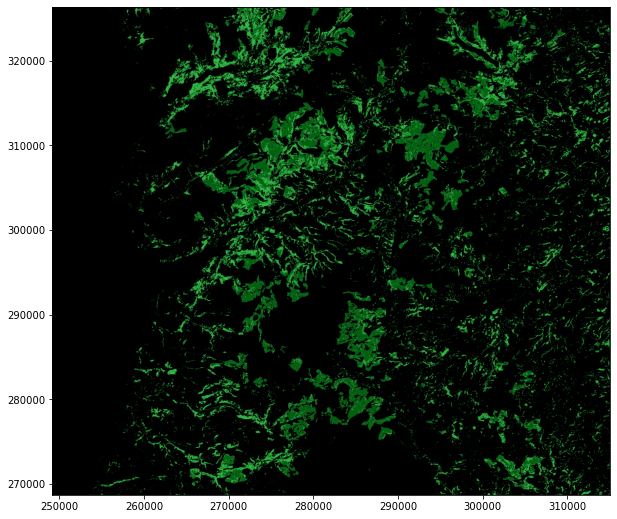

In [23]:
# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_woodytypes_cls_img)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# 8. Classify Other Veg Types

## 8.1 Train Classifier (Other Veg Types)

In [24]:
cls_train_info = dict()
cls_train_info["Bracken"] = ClassInfoObj(
    id=0,
    out_id=1,
    train_file_h5="training_data/bracken_refl_smpls_train.h5",
    test_file_h5="training_data/bracken_refl_smpls_test.h5",
    valid_file_h5="training_data/bracken_refl_smpls_valid.h5",
    red=235,
    green=146,
    blue=38,
)
cls_train_info["Grass_Long"] = ClassInfoObj(
    id=1,
    out_id=2,
    train_file_h5="training_data/grass_long_refl_smpls_train.h5",
    test_file_h5="training_data/grass_long_refl_smpls_test.h5",
    valid_file_h5="training_data/grass_long_refl_smpls_valid.h5",
    red=150,
    green=227,
    blue=18,
)
cls_train_info["Grass_Short"] = ClassInfoObj(
    id=2,
    out_id=3,
    train_file_h5="training_data/grass_short_refl_smpls_train.h5",
    test_file_h5="training_data/grass_short_refl_smpls_test.h5",
    valid_file_h5="training_data/grass_short_refl_smpls_valid.h5",
    red=194,
    green=219,
    blue=66,
)
cls_train_info["Scrub"] = ClassInfoObj(
    id=3,
    out_id=4,
    train_file_h5="training_data/scrub_refl_smpls_train.h5",
    test_file_h5="training_data/scrub_refl_smpls_test.h5",
    valid_file_h5="training_data/scrub_refl_smpls_valid.h5",
    red=0,
    green=80,
    blue=0,
)

# Train the classifier
out_other_veg_mdl_file = os.path.join(out_cls_dir, "otherveg_cls_xgb_mdl.h5")
rsgislib.classification.classxgboost.train_opt_xgboost_multiclass_classifier(
    out_other_veg_mdl_file, cls_train_info
)

Reading Class Bracken Training
Reading Class Bracken Validation
Reading Class Bracken Testing
Reading Class Grass_Long Training
Reading Class Grass_Long Validation
Reading Class Grass_Long Testing
Reading Class Grass_Short Training
Reading Class Grass_Short Validation
Reading Class Grass_Short Testing
Reading Class Scrub Training
Reading Class Scrub Validation
Reading Class Scrub Testing
Finished Reading Data

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 4}
num_boost_round = 31.

AccScore..... 0.9219512195121952 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 4}
num_boost_round = 84.

Ac

## 8.2 Apply Classifier (Other Veg Types)

In [25]:
out_otherveg_cls_img = os.path.join(out_cls_dir, "otherveg_types_cls_xgb.kea")
rsgislib.classification.classxgboost.apply_xgboost_multiclass_classifier(
    cls_train_info,
    out_other_veg_mdl_file,
    out_cls_veg_woody_fnl_img,
    2,
    imgs_info,
    out_otherveg_cls_img,
    "KEA",
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed Classification
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'Bracken'
Apply Colour to class 'Grass_Long'
Apply Colour to class 'Grass_Short'
Apply Colour to class 'Scrub'


## 8.3 Visualise Classification (Other Veg Types)

Image Data Size: 3295 x 2880


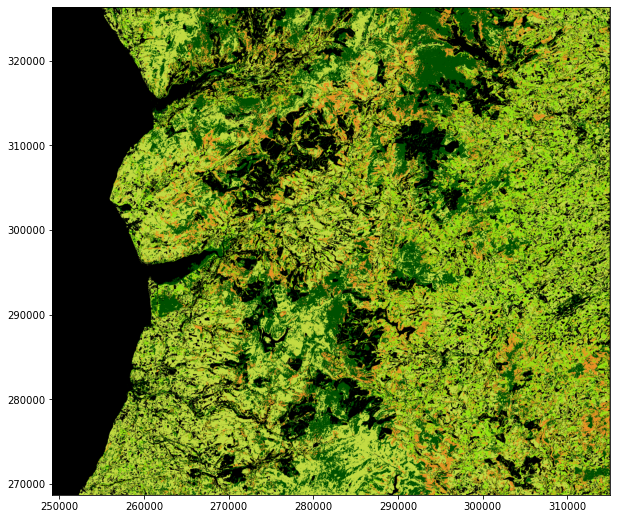

In [26]:
# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_otherveg_cls_img)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# 9. Merge Classification to Create Final Result

## 9.1 Use `band_math` to Merge

In [27]:
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("nonveg", out_cls_fnl_nonveg_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("woody", out_woodytypes_cls_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("oveg", out_otherveg_cls_img, 1))

out_cls_fnl_img = os.path.join(out_cls_dir, "fnl_hier_cls.kea")

exp = """(nonveg==1)?1:(nonveg==2)?2:(nonveg==3)?8:
         (nonveg==4)?10:(woody==1)?4:(woody==2)?5:
         (oveg==1)?3:(oveg==2)?6:(oveg==3)?7:(oveg==4)?9:0"""

rsgislib.imagecalc.band_math(
    out_cls_fnl_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)

rsgislib.rastergis.pop_rat_img_stats(
    out_cls_fnl_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: cls_hier_results/nonveg_fnl_cls.kea
	 Variable 'nonveg' is band 1
Image: cls_hier_results/otherveg_types_cls_xgb.kea
	 Variable 'oveg' is band 1
Image: cls_hier_results/woody_types_cls_xgb.kea
	 Variable 'woody' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 9.2 Update with Class Name and Colours

In [28]:
class_info_dict = dict()
class_info_dict[1] = {
    "classname": "Artificial_Surfaces",
    "red": 160,
    "green": 160,
    "blue": 160,
}
class_info_dict[2] = {
    "classname": "Bare_Rock_Sand",
    "red": 100,
    "green": 100,
    "blue": 100,
}
class_info_dict[3] = {"classname": "Bracken", "red": 235, "green": 146, "blue": 38}
class_info_dict[4] = {"classname": "Conifer_Forest", "red": 2, "green": 97, "blue": 16}
class_info_dict[5] = {
    "classname": "Deciduous_Forest",
    "red": 50,
    "green": 184,
    "blue": 69,
}
class_info_dict[6] = {"classname": "Grass_Long", "red": 150, "green": 227, "blue": 18}
class_info_dict[7] = {"classname": "Grass_Short", "red": 194, "green": 219, "blue": 66}
class_info_dict[8] = {"classname": "NonPhoto_Veg", "red": 98, "green": 225, "blue": 227}
class_info_dict[9] = {"classname": "Scrub", "red": 0, "green": 80, "blue": 0}
class_info_dict[10] = {"classname": "Water", "red": 0, "green": 0, "blue": 255}

rsgislib.rastergis.set_class_names_colours(
    out_cls_fnl_img, "class_names", class_info_dict
)

## 9.3 Visualise Final Result

Image Data Size: 3295 x 2880


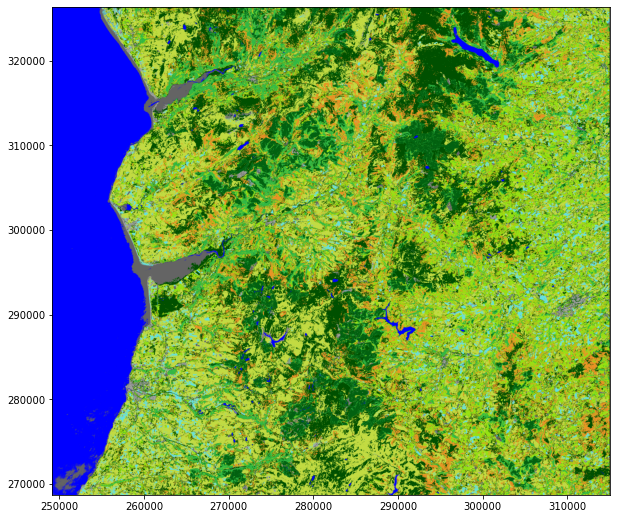

In [29]:
# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_data,
    img_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(out_cls_fnl_img)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data, extent=img_coords)

# 10. Perform Accuracy Assessment

## 10.1 Define Input Reference Points

In [30]:
vec_file = "../data/cls_data/cls_acc_assessment_pts_ref.geojson"
vec_lyr = "cls_acc_assessment_pts_ref"

## 10.2 Copy Existing Points File

To avoid overwriting and editting the input file provided we will first copy it into our output directory.

In [31]:
vec_refpts_file = os.path.join(
    out_pts_dir, "cls_acc_assessment_pts_hier_cls_ref.geojson"
)
vec_refpts_lyr = "cls_acc_assessment_pts_hier_cls_ref"

rsgislib.vectorutils.vector_translate(
    vec_file,
    vec_lyr,
    vec_refpts_file,
    vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True,
)

Deleting: acc_pts/cls_acc_assessment_pts_hier_cls_ref.geojson


 10%|███████████████████▏                                                                                                                                                                          | 101/1000 [00:00<00:00, 7671.16it/s]


## 10.3 Populate Reference Points

In [32]:
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_fnl_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="hier_cls",
    vec_ref_col=None,
    vec_process_col=None,
)

# 12. Filter Valid Points

Some classifiers can produce no data regions and if those intersect with reference points then an error will occur when calculating the accuracy statistics so we need to remove those which we will do using geopandas. For points where there is no class (i.e., no data) in the input classification then the value `"NA"` is outputted into the attribute table and it is rows with an `"NA"` value that we want to remove.


In [33]:
vec_refpts_vld_file = os.path.join(
    out_pts_dir, "cls_acc_assessment_pts_hier_cls_ref_vld.geojson"
)
vec_refpts_vld_lyr = "cls_acc_assessment_pts_hier_cls_ref_vld"
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf = points_gdf.drop(points_gdf[points_gdf["hier_cls"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")
points_gdf

/Users/pete/miniforge3/envs/osgeo-env-v2/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,ref_pts,hier_cls,geometry
0,Bare_Rock_Sand,Artificial_Surfaces,POINT (293492.332 306597.255)
1,Artificial_Surfaces,Artificial_Surfaces,POINT (312462.332 304967.255)
2,Bare_Rock_Sand,Scrub,POINT (306412.332 293567.255)
3,Artificial_Surfaces,Artificial_Surfaces,POINT (259012.332 309877.255)
4,Artificial_Surfaces,Artificial_Surfaces,POINT (305842.332 323467.255)
...,...,...,...
995,Water,Water,POINT (250902.332 316807.255)
996,Water,Water,POINT (257912.332 297147.255)
997,Water,Water,POINT (249762.332 311677.255)
998,Water,Water,POINT (253712.332 295707.255)


# 13. Calculate the Accuracy Statistics

In [34]:
out_json_file = os.path.join(out_stats_dir, "cls_hier_cls_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_hier_cls_acc_info.csv")

calc_acc_metrics_vecsamples(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="ref_pts",
    cls_col="hier_cls",
    cls_img=out_cls_fnl_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

# 14. Reading the JSON file

Let's now have a look at the JSON file which has been outputted. One thing you will notice is this isn't the most user friendly way of presenting this data, hence why the function also outputs a CSV. However, it easy to read out particular values in python, as shown below.

In [35]:
import pprint

cls_acc_stats_dict = rsgislib.tools.utils.read_json_to_dict(out_json_file)
pprint.pprint(cls_acc_stats_dict)

{'Artificial_Surfaces': {'f1-score': 0.6887417218543046,
                         'precision': 0.611764705882353,
                         'recall': 0.7878787878787878,
                         'support': 66},
 'Bare_Rock_Sand': {'f1-score': 0.569767441860465,
                    'precision': 0.5,
                    'recall': 0.6621621621621622,
                    'support': 74},
 'Bracken': {'f1-score': 0.435374149659864,
             'precision': 0.3368421052631579,
             'recall': 0.6153846153846154,
             'support': 52},
 'Conifer_Forest': {'f1-score': 0.8936170212765957,
                    'precision': 1.0,
                    'recall': 0.8076923076923077,
                    'support': 104},
 'Deciduous_Forest': {'f1-score': 0.6011560693641619,
                      'precision': 0.7027027027027027,
                      'recall': 0.5252525252525253,
                      'support': 99},
 'Grass_Long': {'f1-score': 0.6074074074074074,
                'precision': 

In [36]:
print("Overall Accuracy: {}".format(cls_acc_stats_dict["accuracy"]))
print("Macro F1 Score: {}".format(cls_acc_stats_dict["macro avg"]["f1-score"]))
print(
    "Area Weighted F1 Score: {}".format(
        cls_acc_stats_dict["weighted area avg"]["f1-score"]
    )
)

Overall Accuracy: 0.6766766766766766
Macro F1 Score: 0.6682409722461761
Area Weighted F1 Score: 0.6494974942213512


# Summary

You should now be able to run these classifiers through imagery of your own and solve your own classification problems. Things to have a think about:

 1. Which is the 'best' classifier for your problem? 
 2. How can you identify out which is the best classifier for your problem?
 3. How can you optimise the parameters for the classifier you are using and ensure those 'really' are the 'best' parameters?
 4. How much training data do you need? 
 5. Are your sample data well distributed avoiding auto spatial-correlation etc. in your samples.
 6. Where in the scene should training data be taken? Be careful of spatial autocorrelation (i.e., site colated with many pixels next to one other rather than independent.) 
 7. How transferable is your classifier? Can you apply your classifier to other Sentinel-2 images?